In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#some of blocks below are not used.

# Data manipulation
import numpy as np
import pandas as pd

# Data visualisation
import matplotlib.pyplot as plt

# Fastai
from fastai.vision import *
from fastai.vision.models import *

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils
import torchvision.datasets as dset 

from torch import optim
from torch.utils.data import DataLoader,Dataset
from torchvision.models import *
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
#import pretrainedmodels
import torchvision.models as models

from pathlib import Path
import sys

from glob import glob
from PIL import Image

In [3]:
np.random.seed(42)#To make sure that each time you run this kernal, you will get the same beginning parameters.

BATCH_SIZE= 25
NUMBER_EPOCHS=60
IMG_SIZE=100

In [4]:
class SiameseNetwork(nn.Module):# A simple implementation of siamese network, ResNet50 is used, and then connected by three fc layer.
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        model = models.densenet161(pretrained=True)

        #Freezing
        for param in model.parameters():
          param.require_grad = False

        self.cnn1 = torch.nn.Sequential(*(list(model.children())[:-1]))

        model.classifier = nn.Sequential(
            nn.Linear(39744, 460),
            nn.ReLU(),
            nn.Linear(460,2),            
        )

        self.fc = model.classifier 
        
        #self.fc1 = nn.Linear(2*8*100*100, 500)  #2*ultimolayerOutput *IMGSIZE*IMGSIZE
        # self.fc1 = nn.Linear(6000, 1000)
        # self.fc2 = nn.Linear(1000, 500)
        # self.fc3 = nn.Linear(500, 80)
        # self.fc4 = nn.Linear(80, 4)



    def forward(self, input1, input2):#did not know how to let two resnet share the same param.
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)#make it suitable for fc layer.
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)
        
        output = torch.cat((output1, output2),1)
        #print(output.shape) #è l'output che deve aver il primo fc
        output = self.fc(output)
        return output

In [5]:
class testDataset(Dataset): #different from train dataset, because the data organized in submission.csv is different from train.csv
    
    def __init__(self,relationships, transform=None):
        self.relationships = relationships 
        self.transform = transform
        
        
    def __getitem__(self,index):
        row = test_set[index]

        print("riga: ",row)

        img0_path = "/content/drive/MyDrive/kinship_prediction/input/IgnotiPrimaRete/"+row[0]+".png"
        img1_path = "/content/drive/MyDrive/kinship_prediction/input/IgnotiPrimaRete/"+row[1]+".png"

        

        img0 = Image.open(img0_path)
        img1 = Image.open(img1_path)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , row[2] 

    def __len__(self):
        return len(self.relationships)
    


In [6]:
#Come fare shuffle
#from sklearn.utils import shuffle
#test_df = shuffle(test_df)

#importa csv con relazione
test_df  = pd.read_csv("/content/drive/MyDrive/kinship_prediction/input/IgnotiPrimaRete/relationFirstNet3.csv")
test_df.head(20)
test_set = test_df.to_numpy() 


In [7]:
testset = testDataset( relationships = test_set,  transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))

testloader = DataLoader(testset,
                        shuffle= False,
                        num_workers=0,
                        batch_size=1)#Both extra workers and batch size lead to data out of order, the submission.csv will be out of order
#if you have better method, please tell me! thanks a lot!

In [8]:

#Carica un modello con i pesi pre-salvati
PATH = "/content/drive/MyDrive/kinship_prediction/input/firstNet.pth"
model  = torch.load(PATH)

net = model.cuda()

In [9]:
predictions=[]
etichette = []
correct_val = 0
total = 0

with torch.no_grad():
    for data in testloader:
        img0, img1, labels = data
        img0, img1, labels = img0.cuda(), img1.cuda(), labels.cuda()
        outputs = net(img0,img1)
        _, predicted = torch.max(outputs, 1)
        print("predizione:", predicted)
        prob = torch.softmax(outputs, dim=1)
        probClasse0 = round(prob[0][0].item()*100,3)
        probClasse1 = round(prob[0][1].item()*100,3)
        print("Non sono parenti al:", probClasse0, "%  Sono parenti al", probClasse1,"%\n")
        predictions = np.concatenate((predictions,predicted.cpu().numpy()),0)#taking care of here, the output data format is important for transfer

        correct_val += (predicted == labels).sum().item()
        total += labels.size(0)


print(f"Accuratezza del modello: {float(correct_val)/float(total)*100:.2f}")

test_df['Predizione'] = predictions
test_df.to_csv("/content/drive/MyDrive/kinship_prediction/input/MyPredictionPrimaReteIgnoti.csv", index=False)#submission.csv should be placed directly in current fold.
test_df.head(300)#show the result to be committed

riga:  ['17maggio[3]1' '17maggio[3]3' 1]
predizione: tensor([1], device='cuda:0')
Non sono parenti al: 34.648 %  Sono parenti al 65.352 %

riga:  ['17maggio[3]1' '17[maggio]11' 0]
predizione: tensor([1], device='cuda:0')
Non sono parenti al: 39.353 %  Sono parenti al 60.647 %

riga:  ['17maggio[3]1' '17[maggio]21' 0]
predizione: tensor([1], device='cuda:0')
Non sono parenti al: 26.934 %  Sono parenti al 73.066 %

riga:  ['17maggio[3]1' '17[maggio]31' 0]
predizione: tensor([1], device='cuda:0')
Non sono parenti al: 31.419 %  Sono parenti al 68.581 %

riga:  ['17maggio[3]1' '17[maggio]41' 0]
predizione: tensor([1], device='cuda:0')
Non sono parenti al: 36.116 %  Sono parenti al 63.884 %

riga:  ['17maggio[3]1' '17[maggio]51' 0]
predizione: tensor([0], device='cuda:0')
Non sono parenti al: 50.619 %  Sono parenti al 49.381 %

riga:  ['17maggio[3]1' '17[maggio]61' 0]
predizione: tensor([0], device='cuda:0')
Non sono parenti al: 69.446 %  Sono parenti al 30.554 %

riga:  ['17maggio[3]1' '17[

,img1,img2,Parentela,Predizione
0,17maggio[3]1,17maggio[3]3,1,1.0
1,17maggio[3]1,17[maggio]11,0,1.0
2,17maggio[3]1,17[maggio]21,0,1.0
3,17maggio[3]1,17[maggio]31,0,1.0
4,17maggio[3]1,17[maggio]41,0,1.0
5,17maggio[3]1,17[maggio]51,0,0.0
6,17maggio[3]1,17[maggio]61,0,0.0
7,17maggio[3]1,17[maggio]71,0,1.0


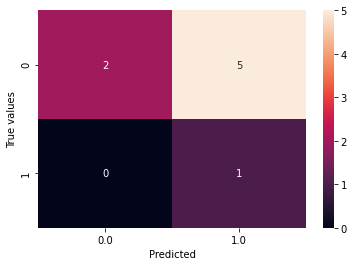

In [10]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

confusion_matrix = pd.crosstab(test_df['Parentela'], test_df['Predizione'], rownames=['True values'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()